## Imports

In [322]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from CellAnalyzer import CellAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data loading and inspection

Create an object with the path to the data.

In [323]:
in_path = "../imaging_data/21122022_images_jinglecells_SO_AK"
ca = CellAnalyzer(in_path)

>>> GPU activated? NO


Display the data table.

In [325]:
table, imgs = ca.read_data()
display(table)

14 images loaded


,condition,donor,time,date,replicate,mode1,mode2,filename,filepath
0,229E,BEC5,48h,2022-12-21,00,R3D,D3D,229E_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
1,229E,BEC5,48h,2022-12-21,02,R3D,D3D,229E_BEC5_48h_21.12.22.02_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
2,229E,BEC5,48h,2022-12-21,03,R3D,D3D,229E_BEC5_48h_21.12.22.03_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
3,229E,BEC6,48h,2022-12-21,01,R3D,D3D,229E_BEC6_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
4,33mock,BEC5,48h,2022-12-21,02,R3D,D3D,33mock_BEC5_48h_21.12.22.02_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
5,33mock,BEC6,48h,2022-12-21,01,R3D,D3D,33mock_BEC6_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
6,33mock,BEC6,48h,2022-12-21,02,R3D,D3D,33mock_BEC6_48h_21.12.22.02_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
7,37mock,BEC5,48h,2022-12-21,00,R3D,D3D,37mock_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
8,37mock,BEC5,48h,2022-12-21,01,R3D,D3D,37mock_BEC5_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
9,37mock,BEC5,48h,2022-12-21,03,R3D,D3D,37mock_BEC5_48h_21.12.22.03_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...


Check dimensions.

In [326]:
imgs[0].shape

(4, 68, 960, 960)

Create projections.

In [327]:
projections = ca.create_projections(types=["max", "max", "max", "max"])

In [328]:
print(projections[0].shape)
print(ca.projections_types)

(4, 960, 960)
['max', 'max', 'max', 'max']


In [330]:
ca.save()

In [331]:
ca2 = CellAnalyzer.load("../imaging_data/21122022_images_jinglecells_SO_AK/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


In [332]:
ca2.df.iloc[:1]

,condition,donor,time,date,replicate,mode1,mode2,filename,filepath,projection_types
0,229E,BEC5,48h,2022-12-21,00,R3D,D3D,229E_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"


In [380]:
masks, flows, styles, imgs_dn, outlines = ca.segment(channels=[3,1])

c:\Users\roman\Documents\Vetsuisse\imaging\CellAnalyzer.py:306: RuntimeWarning: overflow encountered in scalar subtract
  print("new_max:", new_max, "prev_max:", prev_max)


In [ ]:
# Make cell IDs unique (continuing from previous image)
prev_max = 0
new_masks = []
for i, mask in enumerate(masks):
    
    new_mask = mask.copy()
    # Add the number of cells to the DataFrame (as int)
    new_max = mask.max()
    print("prev_max", prev_max, "new_max", mask.max())
    ca.df.at[i, "num_cells"] = new_max - prev_max
    # Make the cell IDs unique
    new_mask += prev_max
    new_mask[new_mask == prev_max] = 0

    # Save the cell IDs in the DataFrame
    ca.df.at[i, "cell_id_min"] = prev_max + 1
    ca.df.at[i, "cell_id_max"] = new_max

    # Set the previous max to the current max
    prev_max = new_mask.max()

    # Append the new mask to the list
    new_masks.append(new_mask)

# Save the new masks in the object
ca.masks = new_masks

prev_max 0 new_max 115
prev_max 115 new_max 24
prev_max 139 new_max 91
prev_max 230 new_max 272
prev_max 502 new_max 341
prev_max 843 new_max 352
prev_max 1195 new_max 339
prev_max 1534 new_max 343
prev_max 1877 new_max 306
prev_max 2183 new_max 331
prev_max 2514 new_max 359
prev_max 2873 new_max 201
prev_max 3074 new_max 259
prev_max 3333 new_max 334


C:\Users\roman\AppData\Local\Temp\ipykernel_10916\1216590254.py:10: RuntimeWarning: overflow encountered in scalar subtract
  ca.df.at[i, "num_cells"] = new_max - prev_max


In [354]:
ca.save_segmentations()

Segmentation results saved.


In [381]:
ca.get_means({"cilia": 4, "inf": 2})

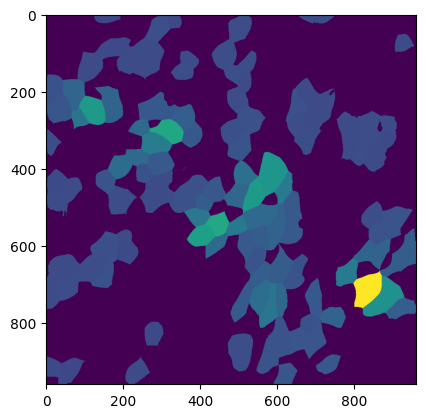

In [382]:
ex_mean_mask = ca.signal_means_masks["inf"][0]
plt.imshow(ex_mean_mask)

In [383]:
ca.df.drop(columns=["time", "date", "mode1", "mode2", "filepath"])

,condition,donor,replicate,filename,projection_types,num_cells,cell_id_min,cell_id_max
0,229E,BEC5,00,229E_BEC5_48h_21.12.22_R3D_D3D.dv,"[max, max, max, max]",115,1,115
1,229E,BEC5,02,229E_BEC5_48h_21.12.22.02_R3D_D3D.dv,"[max, max, max, max]",65445,116,24
2,229E,BEC5,03,229E_BEC5_48h_21.12.22.03_R3D_D3D.dv,"[max, max, max, max]",65488,140,91
3,229E,BEC6,01,229E_BEC6_48h_21.12.22.01_R3D_D3D.dv,"[max, max, max, max]",42,231,272
4,33mock,BEC5,02,33mock_BEC5_48h_21.12.22.02_R3D_D3D.dv,"[max, max, max, max]",65375,503,341
5,33mock,BEC6,01,33mock_BEC6_48h_21.12.22.01_R3D_D3D.dv,"[max, max, max, max]",65045,844,352
6,33mock,BEC6,02,33mock_BEC6_48h_21.12.22.02_R3D_D3D.dv,"[max, max, max, max]",64680,1196,339
7,37mock,BEC5,00,37mock_BEC5_48h_21.12.22_R3D_D3D.dv,"[max, max, max, max]",64345,1535,343
8,37mock,BEC5,01,37mock_BEC5_48h_21.12.22.01_R3D_D3D.dv,"[max, max, max, max]",63965,1878,306
9,37mock,BEC5,03,37mock_BEC5_48h_21.12.22.03_R3D_D3D.dv,"[max, max, max, max]",63684,2184,331


In [384]:
# Make cell IDs unique (continuing from previous image)
prev_max = 0
new_masks = []
for i, mask in enumerate(masks):
    new_mask = mask.copy()
    # Add the number of cells to the DataFrame (as int)
    new_max = mask.max()
    print("new_max:", new_max, "prev_max:", prev_max)
    ca.df.at[i, "num_cells"] = new_max - prev_max
    # Make the cell IDs unique
    new_mask += prev_max
    new_mask[new_mask == prev_max] = 0

    # Save the cell IDs in the DataFrame
    ca.df.at[i, "cell_id_min"] = prev_max + 1
    ca.df.at[i, "cell_id_max"] = new_max

    # Set the previous max to the current max
    prev_max = new_mask.max()

    # Append the new mask to the list
    new_masks.append(new_mask)

# Save the new masks in the object
ca.masks = new_masks

new_max: 115 prev_max: 0
new_max: 24 prev_max: 115
new_max: 91 prev_max: 139
new_max: 272 prev_max: 230
new_max: 341 prev_max: 502
new_max: 352 prev_max: 843
new_max: 339 prev_max: 1195
new_max: 343 prev_max: 1534
new_max: 306 prev_max: 1877
new_max: 331 prev_max: 2183
new_max: 359 prev_max: 2514
new_max: 201 prev_max: 2873
new_max: 259 prev_max: 3074
new_max: 334 prev_max: 3333


C:\Users\roman\AppData\Local\Temp\ipykernel_10916\325787814.py:9: RuntimeWarning: overflow encountered in scalar subtract
  ca.df.at[i, "num_cells"] = new_max - prev_max


In [385]:
results_df = ca.cells_df.drop(columns=["time", "date", "mode1", "mode2", "filepath"])
results_df.iloc[200:205]

,condition,donor,replicate,filename,projection_types,cell_id,cilia_mean,inf_mean


Per condition:

In [386]:
results_df.groupby('condition')[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                 inf_mean            
                  mean          std        mean         std
condition                                                  
229E       5327.759626  1051.878952  1671.21582  1475.48111

Per condition × donor:

In [387]:
results_df.groupby(['condition', 'donor'])[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                        mean          std         mean          std
condition donor                                                    
229E      BEC5   5446.748355  1042.686950  1490.587933  1049.488936
          BEC6   5001.957155  1019.078393  2165.792175  2208.800467

Per replicate (to detect batch effects):

In [388]:
results_df.groupby(['condition', 'replicate'])[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                            mean          std         mean          std
condition replicate                                                    
229E      00         5446.748355  1042.686950  1490.587933  1049.488936
          01         5001.957155  1019.078393  2165.792175  2208.800467

Visualize

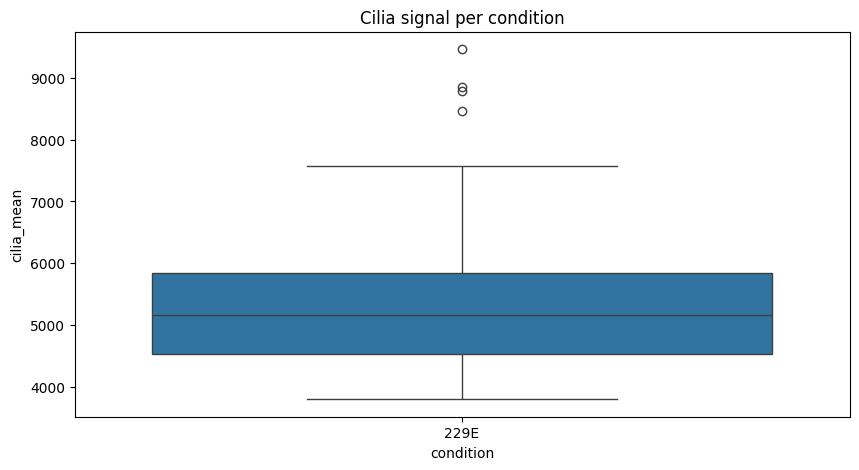

In [389]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='condition', y='cilia_mean')
plt.title('Cilia signal per condition')
plt.show()

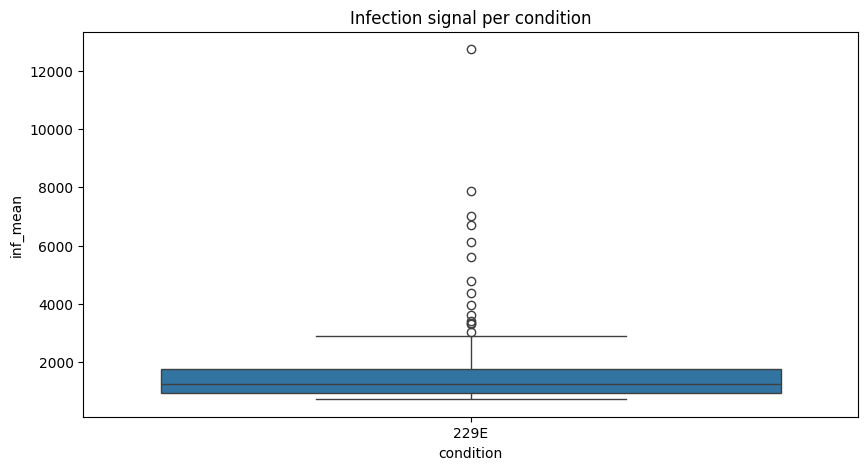

In [390]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='condition', y='inf_mean')
plt.title('Infection signal per condition')
plt.show()

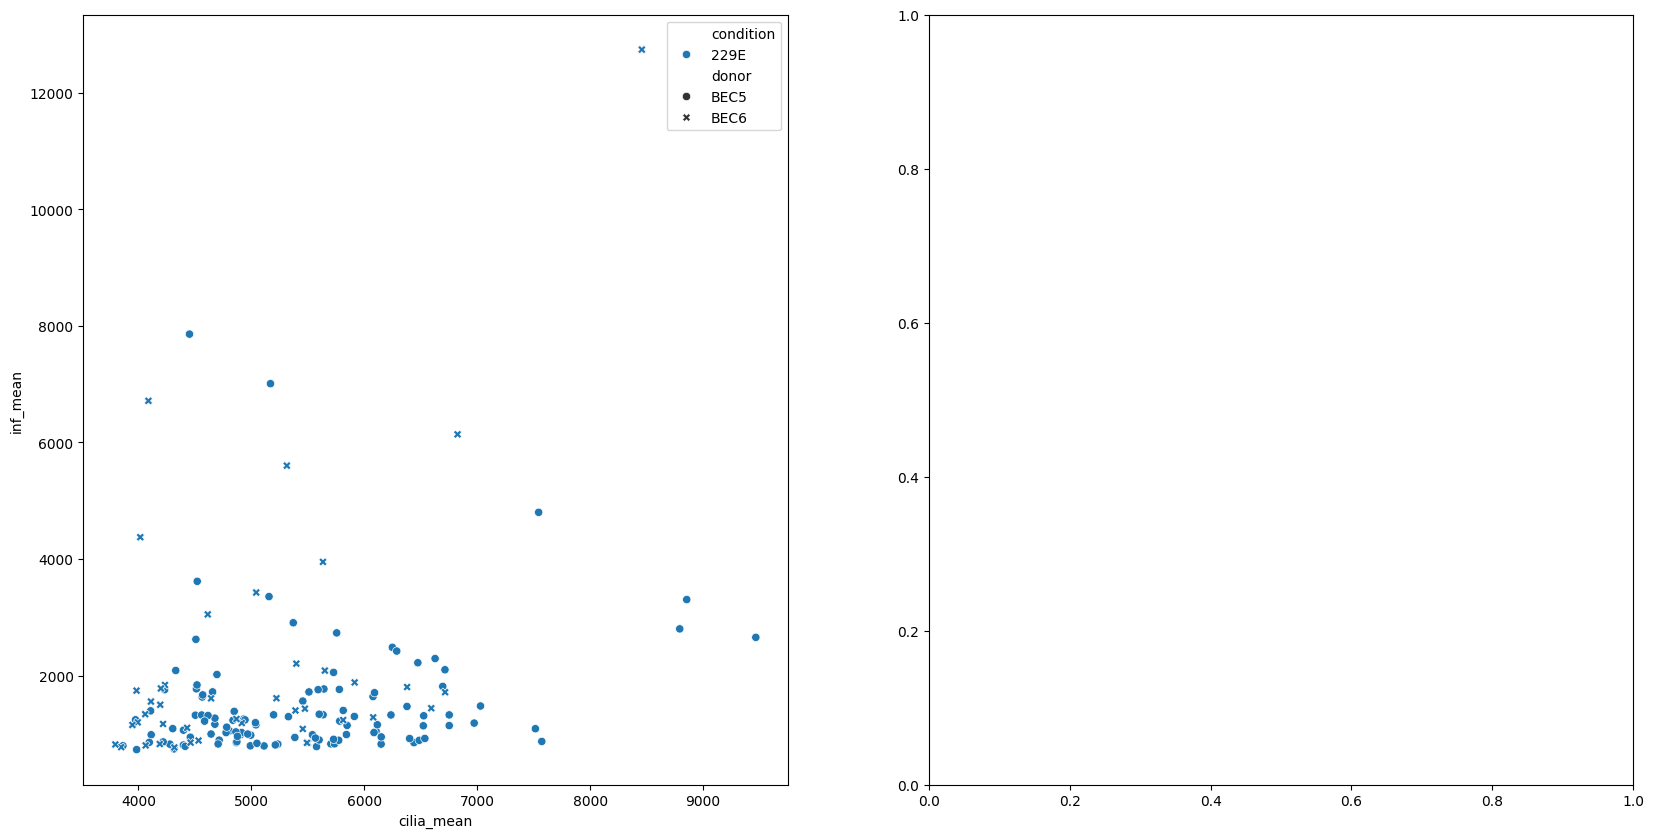

In [391]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, sub in enumerate([("229E", "33mock"), ("MERS", "37mock")]):
    # Filter the two conditions out of the dataframe
    sub_df = results_df.loc[(results_df['condition'] == sub[0]) | (results_df['condition'] == sub[1])]
    # Create a scatter plot for the two conditions
    sns.scatterplot(data=sub_df, x='cilia_mean', y='inf_mean', hue="condition", style="donor", ax=ax[i])
plt.show()

Make meaningful summary.

In [392]:
replicate_summary = results_df.groupby(['condition', 'donor', 'replicate'])[
    ['cilia_mean', 'inf_mean']
].mean().reset_index()
replicate_summary

,condition,donor,replicate,cilia_mean,inf_mean
0,229E,BEC5,00,5446.748355,1490.587933
1,229E,BEC6,01,5001.957155,2165.792175


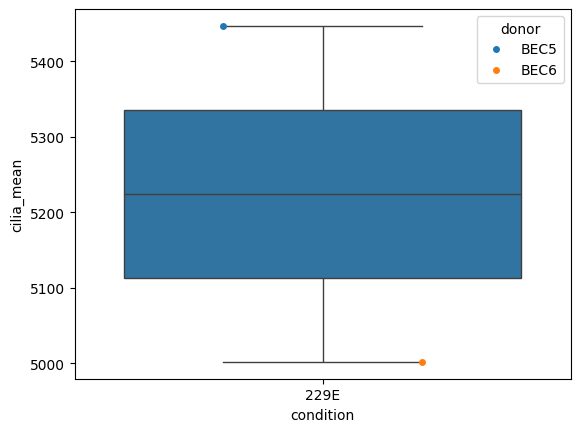

In [393]:
sns.boxplot(data=replicate_summary, x="condition", y="cilia_mean")
sns.stripplot(data=replicate_summary, x="condition", y="cilia_mean", hue="donor", dodge=True)
plt.show()

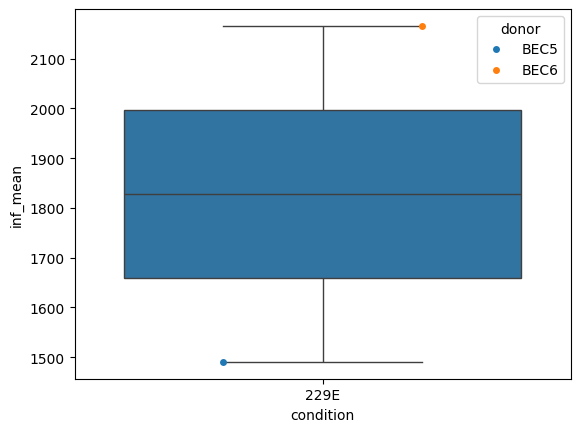

In [394]:
sns.boxplot(data=replicate_summary, x="condition", y="inf_mean")
sns.stripplot(data=replicate_summary, x="condition", y="inf_mean", hue="donor", dodge=True)
plt.show()